# Tutorial 2: scRNA and ST data integration (deconvolution)

In this tutorial, we show how to apply GraphST to integrate scRNA-seq and ST data, i.e., deconvolution. Taking human lymph node dataset as example, both scRNA-seq and ST data were downloaded from an existing study by Kleshchevnikov et al. and provided at https://drive.google.com/drive/folders/1ns-EsWBu-SNrJ39j-q-AFIV5U-aXFwXf. 

After downloading the data, we can obtain 'scRNA.h5ad' and 'ST.h5ad' files, which are corresponding reference and spatial transcriptomics data respectively. Cell type information is included in scRNA.obs['cell_type'].  

In [8]:
import scanpy as sc
from GraphST import GraphST

In [9]:
dataset = 'Human_Lymph_Node'

# Reading ST data

In [10]:
# read ST data
file_fold = '/home/yahui/Yahui/Projects/data/Human_Lymph_Node/' #Please replace 'file_fold' with the ST download path 
adata = sc.read_h5ad(file_fold + 'ST.h5ad')
    
#For '10X' ST data, please read it instead as:
#file_fold = '/home/yahui/Yahui/Projects/data/' + str(dataset) #Please replace it with the ST download path 
#adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)

adata.var_names_make_unique()

# Pre-processing for ST data

In [11]:
# preprocessing for ST data
GraphST.preprocess(adata)

# build graph
GraphST.construct_interaction(adata)
GraphST.add_contrastive_label(adata)

# Reading reference data

In [12]:
# read scRNA daa
file_path = '/home/yahui/Yahui/Projects/data/Human_Lymph_Node/scRNA.h5ad' # Please replace 'file_path' with the scRNA download path. 
adata_sc = sc.read(file_path)
adata_sc.var_names_make_unique()

# Pre-processing for reference data

In [13]:
# preprocessing for scRNA data
GraphST.preprocess(adata_sc)

# Finding overlap genes between ST and reference data

In [14]:
# find overlap genes
from GraphST.preprocess import filter_with_overlap_gene
adata, adata_sc = filter_with_overlap_gene(adata, adata_sc)

Number of overlap genes: 1313


/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


# Extracting features for ST data

In [15]:
# get features
GraphST.get_feature(adata)

# Implementing GraphST for cell type deconvolution

In [16]:
import torch
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Train model
model = GraphST.GraphST(adata, adata_sc, epochs=1200, random_seed=50, device=device, deconvolution=True)
adata, adata_sc = model.train_map()

Begin to train ST data...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.63it/s]


Optimization finished for ST data!
Begin to train scRNA data...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:20<00:00, 59.78it/s]


Optimization finished for cell representation learning!
Begin to learn mapping matrix...


100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [02:02<00:00,  9.80it/s]


Mapping matrix learning finished!


# Visualization of single cell data distribution in ST tissue

After model training, we can obtain the learned mapping matrix with dimension 'n_spot x n_cell' in adata.obsm['map_matrix']. 
Each element in the mapping matrix denotes the mapping probability of a cell in a given spot. To filter out noise, we only consider
the top 'retain_percent' cell values for each spot.

We usually set the 'retain_percent' value as 0.15. Users can change the parameter according to your requirement. 

In [17]:
# Project cells into spatial space
from GraphST.utils import project_cell_to_spot
project_cell_to_spot(adata, adata_sc, retain_percent=0.15)

After projection, the probability distributions of each cell type in spots are saved in adata.obs.

In [18]:
adata

AnnData object with n_obs × n_vars = 4035 × 1313
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'B_Cycling', 'B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB', 'B_IFN', 'B_activated', 'B_mem', 'B_naive', 'B_plasma', 'B_preGC', 'DC_CCR7+', 'DC_cDC1', 'DC_cDC2', 'DC_pDC', 'Endo', 'FDC', 'ILC', 'Macrophages_M1', 'Macrophages_M2', 'Mast', 'Monocytes', 'NK', 'NKT', 'T_CD4+', 'T_CD4+_TfH', 'T_CD4+_TfH_GC', 'T_CD4+_naive', 'T_CD8+_CD161+', 'T_CD8+_cytotoxic', 'T_CD8+_naive', 'T_TIM3+', 'T_TfR', 'T_Treg', 'VSMC'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'overlap_genes'
    obsm: 'MT', 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb_sp', 'map_matrix'

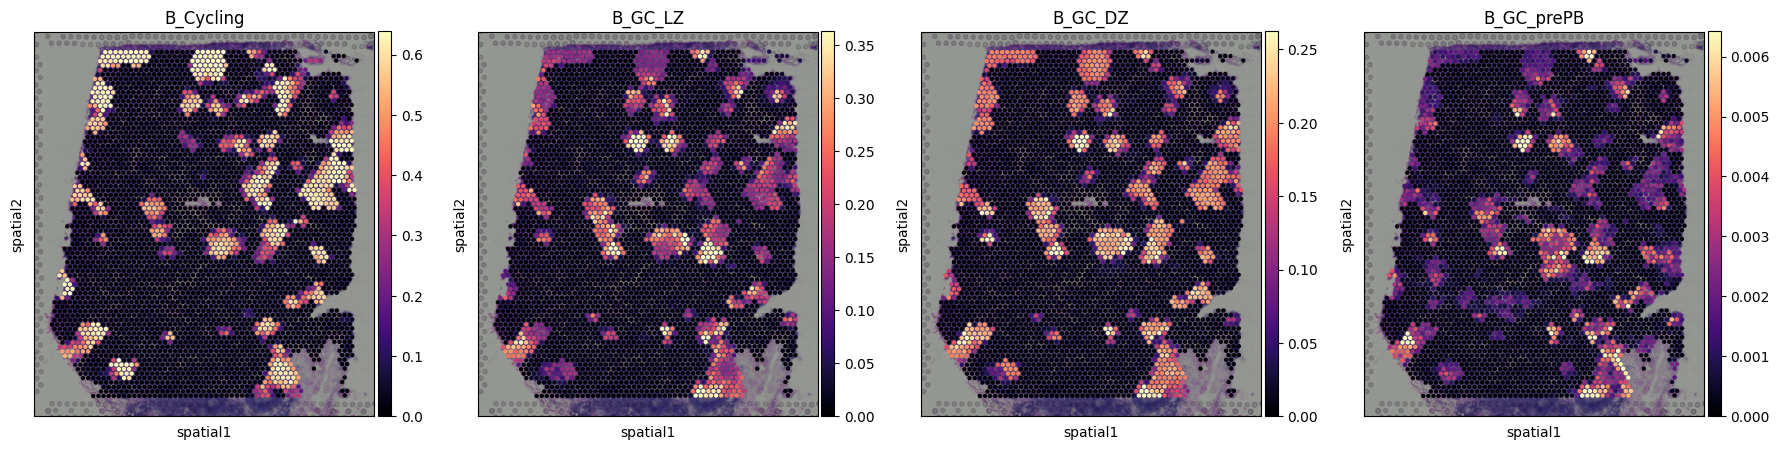

In [19]:
# Visualization of spatial distribution of scRNA-seq data
import matplotlib as mpl
import matplotlib.pyplot as plt
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

         sc.pl.spatial(adata, cmap='magma',
                  # selected cell types
                  color=['B_Cycling', 'B_GC_LZ', 'B_GC_DZ', 'B_GC_prePB'], 
                  ncols=5, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  show=True
                 )